In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

In [42]:
# Download stock data
def fetch_stock_data(ticker, start='2020-01-01', end='2024-10-01'):
    data = yf.download(ticker, start=start, end=end)

    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [col[0] for col in data.columns]

    data['Return'] = data['Close'].pct_change()

    data['MA5'] = data['Close'].rolling(window=5).mean()
    data['MA20'] = data['Close'].rolling(window=20).mean()
    data['RSI'] = calculate_rsi(data['Close'], 14)

    data['Forward_Return'] = data['Return'].shift(-1)

    data['Target'] = np.where(data['Forward_Return'] > 0.01, 2,  # Buy
                             np.where(data['Forward_Return'] < -0.01, 0,  # Sell
                                     1))  # Hold
    data.dropna(inplace=True)

    print(f"Class distribution: {data['Target'].value_counts()}")
    
    return data[['Close', 'Volume', 'Return', 'MA5', 'MA20', 'RSI', 'Target']]

# Helper function for RSI calculation
def calculate_rsi(close_prices, period=14):
    delta = close_prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

#Custom dataset class with normalization
class StockDataset(Dataset):
    def __init__(self, data, seq_length=30):
        features = data.iloc[:, :-1].values
        targets = data.iloc[:, -1].values
        
        # Normalize features
        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(features)
        self.targets = targets.astype(np.int64)
        self.seq_length = seq_length
    
    def __len__(self):
        return len(self.features) - self.seq_length
    
    def __getitem__(self, idx):
        x = self.features[idx:idx + self.seq_length]
        y = self.targets[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Improved positional encoding compatible with batch_first=True
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(1, max_len, d_model)  # Shape: [1, max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerStockPredictor(nn.Module):
    def __init__(self, input_dim=6, d_model=64, nhead=4, num_layers=3, dim_feedforward=128, dropout=0.1):
        super(TransformerStockPredictor, self).__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Create transformer with dropout for regularization
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # Multiple classification heads for better learning
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 3)  # 3 classes: Sell (0), Hold (1), Buy (2)
        )
        
        # Initialize weights for better convergence
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, src):
        src = self.input_projection(src)
        src = self.pos_encoder(src)
        
        # Apply attention mask to focus on more recent data
        seq_len = src.size(1)
        mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1).to(src.device)
        
        output = self.transformer_encoder(src, mask=mask)
        
        # Use the last sequence element for prediction
        output = self.classifier(output[:, -1, :])
        return output

In [47]:
# Load data with more features
ticker = 'GOOG'
data = fetch_stock_data(ticker)
dataset = StockDataset(data)

# Split data with time-based approach (better for time series)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model setup with correct input dimension
input_dim = data.shape[1] - 1
model = TransformerStockPredictor(input_dim=input_dim)

# Get class weights based on frequency
class_counts = np.bincount(data['Target'].astype(int))
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum() 
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Use lower learning rate with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Add learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training loop with early stopping
best_test_acc = 0
patience = 5
counter = 0
num_epochs = 50 

train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch in train_loader:
        x_batch, y_batch = batch
        optimizer.zero_grad()
        
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        # Add gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_train_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == y_batch).sum().item()
        train_total += y_batch.size(0)
    
    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluation phase
    model.eval()
    epoch_test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            outputs = model(x_batch)
            
            loss = criterion(outputs, y_batch)
            epoch_test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == y_batch).sum().item()
            test_total += y_batch.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
    
    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)

    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Update learning rate based on validation loss
    avg_test_loss = epoch_test_loss / len(test_loader) 
    scheduler.step(avg_test_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {epoch_train_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
    
    # Print prediction distribution
    if epoch % 5 == 0:
        unique, counts = np.unique(all_preds, return_counts=True)
        print(f"Prediction distribution: {dict(zip(unique, counts))}")
    
    # Early stopping
    if test_accuracy > best_test_acc:
        best_test_acc = test_accuracy
        torch.save(model.state_dict(), f'{ticker}_best_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

# After training, get confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
print(f"Confusion Matrix:\n{cm}")
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=['Sell', 'Hold', 'Buy']))

[*********************100%***********************]  1 of 1 completed


Class distribution: Target
1    572
2    322
0    280
Name: count, dtype: int64
Epoch 1/50
Train Loss: 1.1709, Train Acc: 33.77%
Test Loss: 1.1192, Test Acc: 41.92%
Prediction distribution: {0: 83, 1: 146}
Epoch 2/50
Train Loss: 1.1337, Train Acc: 35.74%
Test Loss: 1.0959, Test Acc: 24.02%
Epoch 3/50
Train Loss: 1.1244, Train Acc: 34.10%
Test Loss: 1.0840, Test Acc: 43.23%
Epoch 4/50
Train Loss: 1.1060, Train Acc: 36.83%
Test Loss: 1.1005, Test Acc: 46.72%
Epoch 5/50
Train Loss: 1.1056, Train Acc: 40.44%
Test Loss: 1.0998, Test Acc: 50.22%
Epoch 6/50
Train Loss: 1.1043, Train Acc: 41.53%
Test Loss: 1.1076, Test Acc: 48.03%
Prediction distribution: {1: 169, 2: 60}
Epoch 7/50
Train Loss: 1.0966, Train Acc: 43.83%
Test Loss: 1.1029, Test Acc: 48.03%
Epoch 8/50
Train Loss: 1.0816, Train Acc: 46.99%
Test Loss: 1.0786, Test Acc: 49.34%
Epoch 9/50
Train Loss: 1.0775, Train Acc: 46.45%
Test Loss: 1.0821, Test Acc: 50.66%
Epoch 10/50
Train Loss: 1.0770, Train Acc: 47.98%
Test Loss: 1.0770, Test

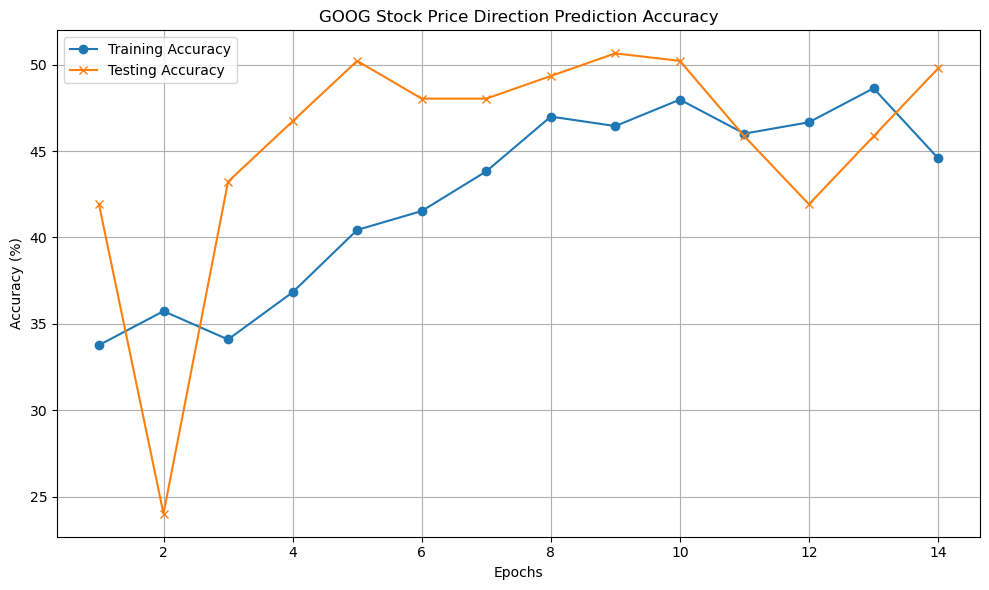

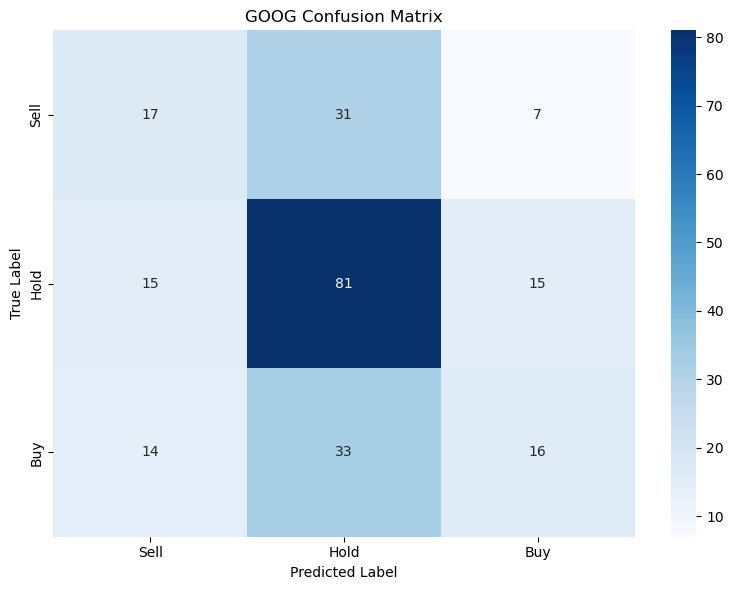

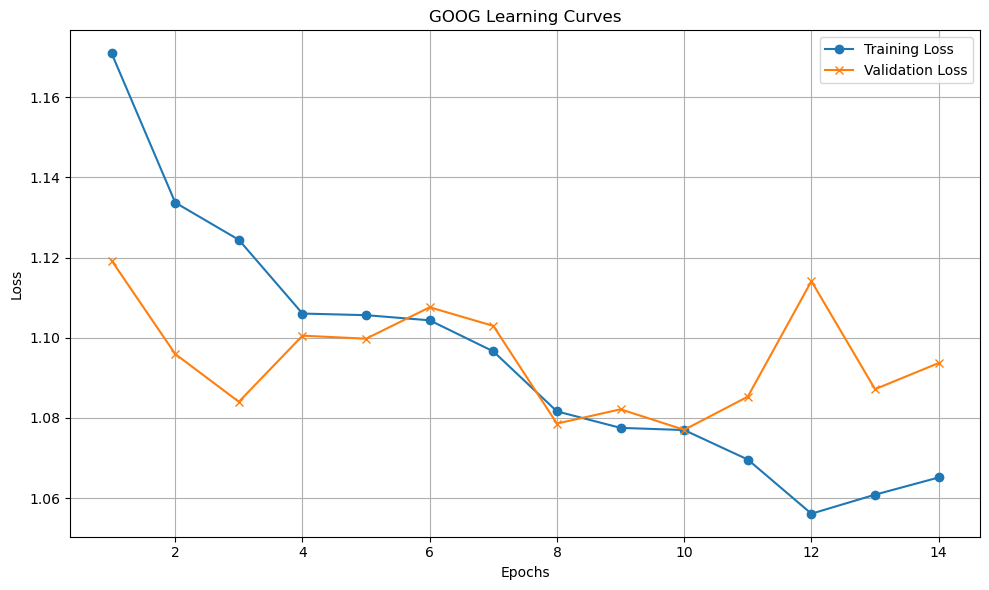

In [51]:
# Plot training and testing accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Testing Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title(f'{ticker} Stock Price Direction Prediction Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Also plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sell', 'Hold', 'Buy'],
            yticklabels=['Sell', 'Hold', 'Buy'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{ticker} Confusion Matrix')
plt.tight_layout()

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker = 'o')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Validation Loss', marker = 'x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{ticker} Learning Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{ticker}_learning_curves.png')
plt.show()